# 3 NFT Wash trading

In this exercise we will be looking at a case of NFT wash trading. We will be looking at a very small snapshot of a collection of [Audioglyph NFTs](https://opensea.io/collection/audioglyphs).

We will need to obtain trade events from OpenSea, because wash trading would only make sense if the wash traded volume would actually appear on a trading platform.

OpenSea emits **OrdersMatched** events when there was an NFT sale. Unfortunately though, these events do not contain the id of the NFT that has been sold. So we will need to look at both **OrdersMatched** events and **Transfer** events. OpenSea however has millions of these OrdersMatched events, and so it is not easy to obtain just the trades of a particular type of NFT.

The solution is to find all transactions where a Transfer event was emitted, and then check whether these transactions also led to the emittance of an OpenSea trading event. We could use the OpenSea API directly, but the point here is to show how to access the on-chain data.

As in the previous excercise, please use your own endpoint URL. You can create a free account with [Moralis.io](https://admin.moralis.io/register), and get an endpoint URL from them. You may be able to use this notebook endpoint, but you may run into rate limits if other participants are using it at the same time. Or at a later point in time this endpoint may not work at all anymore.

In [1]:
endpoint = "https://speedy-nodes-nyc.moralis.io/03c966587b022c980f59136b/eth/mainnet/archive"

In [2]:
from web3 import Web3
w3 = Web3(Web3.HTTPProvider(endpoint))
w3.isConnected()

True

# 3.1 Get transaction hashes of Audioglyphs NFT transfers
At first, we will need to get a list of transaction hashes where NFT token transfers related to the Audioglyphs NFT collection have been emitted. We do this in a very similar fashion to how we've done it in the previous exercise, by accessing Transfer events in a given block interval.

In [3]:
from tqdm.notebook import tqdm

AudioglyphsTokenContractAddress = "0xfb3765e0e7ac73e736566af913fa58c3cfd686b7"

blockStart =  14200000 
blockEnd = blockStart + 10000
blockRange = 2000 # Moralis only supports a maximum of 2000

txHashList = []
for blockNumber in tqdm(range(blockStart, blockEnd, blockRange)):
    response = w3.eth.get_logs({"fromBlock": str(hex(blockNumber)),
                                "toBlock": str(hex(min(blockEnd, blockNumber+blockRange))),
                                "address": Web3.toChecksumAddress(AudioglyphsTokenContractAddress),
                                "topics": [Web3.keccak(text='Transfer(address,address,uint256)').hex()]})
    for item in response:
        txHashList.append(item.transactionHash.hex())
txHashList = list(set(txHashList)) # remove duplicates
print("Got",len(txHashList), "transactions with transfers")

  0%|          | 0/5 [00:00<?, ?it/s]

Got 39 transactions with transfers


# 3.2 Get Transfer and OrdersMatched events related to these tx hashes
Given these transaction hashes, we can now check whether these transactions also led to OpenSea OrdersMatched events, and extract them along with the Audioglyphs Transfer events. We do this using the ABIs of both Audioglyphs and OpenSea, which are stored in this repository in JSON format.

In [4]:
from pathlib import Path
from web3.logs import STRICT, IGNORE, DISCARD, WARN

OpenSeaContractAddress = "0x7f268357A8c2552623316e2562D90e642bB538E5"

transferEvents = []
ordersMatchedEvents = []

NFTContract = w3.eth.contract(address=Web3.toChecksumAddress(AudioglyphsTokenContractAddress),
                              abi=Path('ABIs/AudioGlyphs.json').read_text())
OpenSeaContract = w3.eth.contract(address=Web3.toChecksumAddress(AudioglyphsTokenContractAddress),
                                  abi=Path('ABIs/OpenSea.json').read_text())

def createCustomLogStructure(log):
    log = dict(log)
    log["transactionHash"] = log["transactionHash"].hex()
    del log["blockHash"]
    for k,v in log["args"].items():
        log[k] = v
    del log["args"]
    return(log)

for txHash in tqdm(txHashList):
    receipt = w3.eth.getTransactionReceipt(txHash)
    transferLogs = NFTContract.events.Transfer().processReceipt(receipt, errors=DISCARD)
    for log in transferLogs:
        log = createCustomLogStructure(log)
        transferEvents.append(log)
    
    ordersMatchedLogs = OpenSeaContract.events.OrdersMatched().processReceipt(receipt, errors=DISCARD)
    for log in ordersMatchedLogs:
        log = createCustomLogStructure(log)
        ordersMatchedEvents.append(log)        

  0%|          | 0/39 [00:00<?, ?it/s]

# 3.3 Creating pandas dataframes, and joining the datasets
We have now obtained the events, can create pandas dataframes from them and merge them based on the transactionHash. In addition, we label whether a certain transfer was seen as part of a sale, or whether it was just a simple transfer, and we perform a count of how often we see the same source, target type of transfer of the same NFT id to get a first impression.

In [5]:
# Convert lists to pandas dataframes
import pandas as pd
transferEventsDF = pd.DataFrame(transferEvents)
ordersMatchedEventsDF = pd.DataFrame(ordersMatchedEvents)

orders = ordersMatchedEventsDF[["transactionHash", "price"]]
transfers = transferEventsDF[["transactionHash", "from", "to", "tokenId"]]

transfersLabeled = pd.merge(transfers, orders, how="left")

# A transfer is part of a sale if it has a positive price value
transfersLabeled['type'] = transfersLabeled['price'].apply(lambda x: 'sale' if x>=0 else 'transfer')

#
transfersGrouped = transfersLabeled.groupby(["from", "to", "tokenId", "type"]).agg(
    {'transactionHash':'count'}).sort_values("to", ascending=False)
transfersGrouped = transfersGrouped.rename(columns = {"transactionHash":"count"})
transfersGrouped.reset_index(inplace = True)
transfersGrouped.sort_values("count", ascending=False).head()

,from,to,tokenId,type,count
6,0xA2a8894C5533133f7c676AB6a2922506666E631D,0xA7D30065391e7c2FDBbE7D2D495feb1E2E4d332c,1935,sale,7
7,0xA7D30065391e7c2FDBbE7D2D495feb1E2E4d332c,0xA2a8894C5533133f7c676AB6a2922506666E631D,1935,sale,6
9,0x99C052567B617345398c9a6491C247ffD94Af2c5,0x9b0AF8E61bbB1D8C6F43aF0AF752c257Cfc2b292,1935,sale,6
11,0x9b0AF8E61bbB1D8C6F43aF0AF752c257Cfc2b292,0x99C052567B617345398c9a6491C247ffD94Af2c5,1935,sale,6
0,0x0061e7958aA1f6bbDA7fFdB4D079fa2d413263dd,0xf1a9CF974fE40ED829E7Fd601446d3c58780cF8d,5005,sale,1


# 3.4 Create a network of NFT transfers
We create a network of NFT transfers based on the grouped dataframe above, with edge attributes count, token (NFT) id, and type (sale or transfer).

We then draw the network:
- Highlighting sales with blue edges
- Highlighting transfers with green edges
- Displaying edge width according to their count
- Displaying an edge label with the NFT id

In [6]:
import networkx as nx
G = nx.from_pandas_edgelist(df=transfersGrouped,
                            source="from", target="to",
                            edge_attr=["count","tokenId", "type"],
                            create_using=nx.DiGraph)

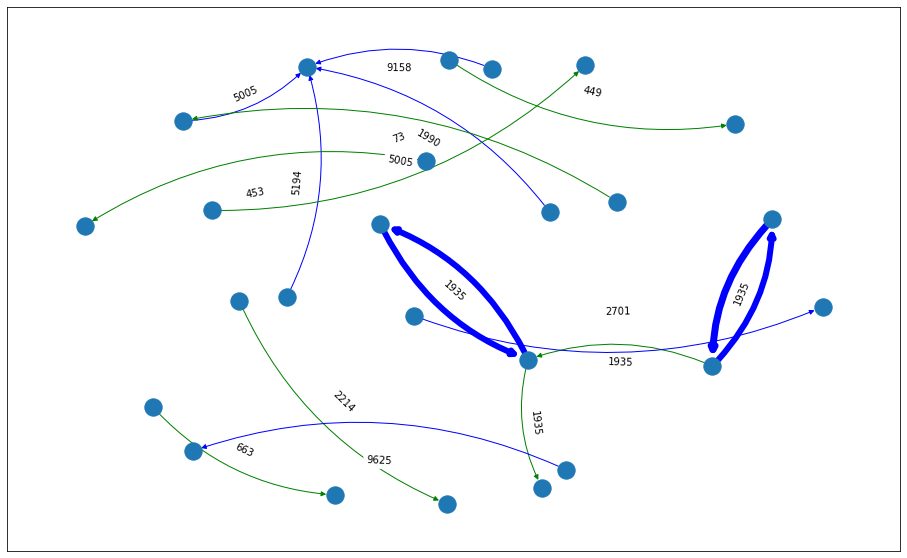

In [7]:
# Draw nodes and edges
import matplotlib.pyplot as plt

labels = nx.get_edge_attributes(G, 'tokenId')
widths = nx.get_edge_attributes(G, 'count').values()
colors = nx.get_edge_attributes(G, 'type').values()
colors = ["b" if color == "sale" else "g" for color in colors]

pos=nx.spring_layout(G, k=2, iterations=100, seed=5)

plt.figure(1,figsize=(16,10))
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos, connectionstyle="arc3,rad=0.2", width=list(widths), edge_color=colors)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

From this we can already spot that there are two groups of each two accounts that repeatedly trade the NFT id 1935 among them.

# 3.5 Showing only the graph of a single NFT id
To remove the clutter, let's draw only the Audioglyph NFT with id 1935, by creating a subgraph based on the edges with the corresponding NFT id property:

In [8]:
def drawTokenId(tokenId):
    selected_edges = [(u,v) for u,v in G.edges if G[u][v]['tokenId'] == 1935]
    selected_nodes = [item for sublist in selected_edges for item in sublist]
    G_sub = G.subgraph(selected_nodes)
    labels = nx.get_edge_attributes(G_sub, 'tokenId')
    widths = nx.get_edge_attributes(G_sub, 'count').values()
    colors = nx.get_edge_attributes(G_sub, 'type').values()
    colors = ["b" if color == "sale" else "g" for color in colors]


    plt.figure(1,figsize=(16,10))
    nx.draw_networkx_nodes(G_sub, pos)
    nx.draw_networkx_edges(G_sub, pos, connectionstyle="arc3,rad=0.2", width=list(widths), edge_color=colors)
    nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=labels)
    plt.show()

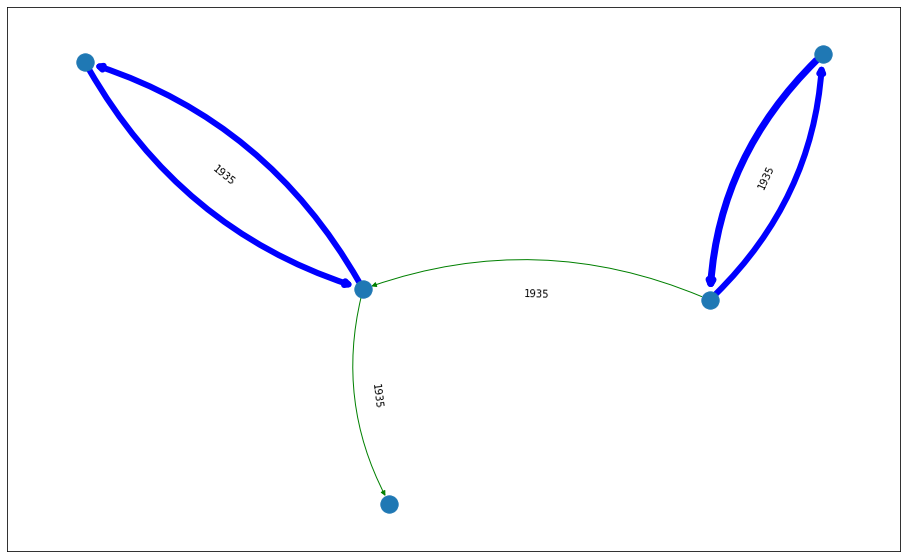

In [9]:
drawTokenId(1935)

Interestingly, this shows that Audioglyphs NFT id 1935 has been traded in cycles multiple times, but also that the NFT was then transfered and traded in cycles again, before ultimately ending up at a final account.

This is not very sophisticated wash trading, and in fact OpenSea appears to hide these trades from their user interface, and also doesn't show the corresponding trade volume. This is because they want to protect their users.

Whether the final buyer is also the one who owns the other acccounts can only be speculated upon, but it is likely that the wash trading accounts belong to the same entity.